In [1]:
from net.parse import *
from net import *

In [2]:
DELTA = 3
CONTEXT = 10

In [3]:
# Build dataset
trends = merge_on_date(parse_path(Path('../data/trends'))) # Parse trends data
stats = get_data() # Parse stats data
x_train, y_train, x_test, y_test, mean, std = build_data(trends, stats, DELTA, CONTEXT)

/Users/tudor/CS-Work/ML/P3/VFNN/src/net/parse/finance_parser.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daily = yf.download(tickers='^SPX', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Model Hyperparameters
HIDDEN = 256
INPUT_SIZE = 28 # Fixed
MLP_SIZE = (256, 1) # Has to end in 1
BATCH_SIZE = 32
STEPS = 50000
LR = 1e-3
LAMBDA_ = 1e-4

In [5]:
# Initialize
model = VFNN(HIDDEN, INPUT_SIZE, MLP_SIZE)

Loss: 0.1250167340040207 on step: 1
Loss: 0.1518188714981079 on step: 101
Loss: 0.6886073350906372 on step: 201
Loss: 0.3282146751880646 on step: 301
Loss: 0.5022649168968201 on step: 401
Loss: 0.23680144548416138 on step: 501
Loss: 0.43203437328338623 on step: 601
Loss: 0.15015779435634613 on step: 701
Loss: 0.23260420560836792 on step: 801
Loss: 0.404382586479187 on step: 901
Loss: 0.15992367267608643 on step: 1001
Loss: 0.21189315617084503 on step: 1101
Loss: 0.25564759969711304 on step: 1201
Loss: 0.08919907361268997 on step: 1301
Loss: 0.08928583562374115 on step: 1401
Loss: 0.14499473571777344 on step: 1501
Loss: 0.1962129771709442 on step: 1601
Loss: 0.8514895439147949 on step: 1701
Loss: 0.257201611995697 on step: 1801
Loss: 0.47980454564094543 on step: 1901
Loss: 0.18362432718276978 on step: 2001
Loss: 0.2786685526371002 on step: 2101
Loss: 0.573947548866272 on step: 2201
Loss: 0.4090563654899597 on step: 2301
Loss: 1.2029600143432617 on step: 2401
Loss: 0.3543587028980255 on 

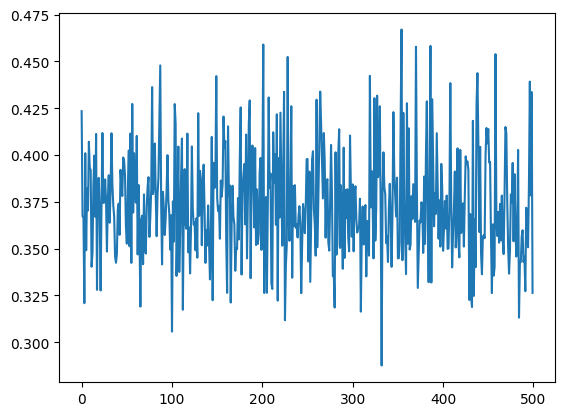

In [10]:
# Train
model.train()
lossi = adam(model, RMSE, x_train, y_train, LR * 0.1, LAMBDA_, BATCH_SIZE, STEPS + 30000)

# Plot loss
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [11]:
model.eval()
vals = model.forward(x_train)
loss = RMSE(vals, y_train)
print(loss.item())
print(MAPE(vals, y_train, mean[:, -2], std[:, -2]).item())

0.10927682369947433
11.938151359558105


In [12]:
model.eval()
vals = model.forward(x_test)
loss = RMSE(vals, y_test)
print(loss.item())
print(MAPE(vals, y_test, mean[:, -2], std[:, -2]).item())

0.6029205918312073
38.892452239990234
